# Characterization of Discrete Systems in the Spectral Domain

*This Jupyter notebook is part of a [collection of notebooks](../index.ipynb) in the bachelors module Signals and Systems, Communications Engineering, Universität Rostock. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Measurement of an Electroacoustic Transfer Function

The propagation of sound from a loudspeaker placed at one position in a room to a microphone placed at another position can be interpreted as system. The system can be regarded as linear time-invariant (LTI) system under the assumption that the [sound pressure level](https://en.wikipedia.org/wiki/Sound_pressure#Sound_pressure_level) is kept reasonably low (e.g. $L_p < 100$ dB, **pay attention to your ears**) and neither the loudspeaker nor the microphone are 'overdriven'. Consequently, its impulse response $h(t)$ characterizes the propagation of sound between theses two positions. Room impulse responses (RIRs) have a wide range of applications in acoustics, e.g. for the characterization of electroacoustic equipment, room acoustics or auralization. Therefore their measurement and modeling by discrete systems has found a lot of attention in digital signal processing.
Similarly, electromagnetic wave radiation between a transmitter and a receiver could be modeled as a linear transmission channel.

The following example demonstrates how an electroacoustic transfer function can be measured and [modeled by an finite impulse response (FIR) system](transfer_function.ipynb#Modeling-a-Continuous-System-by-a-Discrete-System) using the soundcard of a computer. The module [`sounddevice`](http://python-sounddevice.readthedocs.org/) provides access to the soundcard via [`portaudio`](http://www.portaudio.com/). The basic procedure involves the following three steps

1. generation of the measurement signal $x[k]$,
2. playback of measurement signal $x(t)$ and synchronous recording of system response $y(t)$ (digitalization to $y[k]$), and
3. computation of transfer function $H[\mu]$ and impulse response $h[k]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import sounddevice as sd
%matplotlib inline

fs = 44100  # sampling rate
T = 10  # length of measurement signal in s
Tr = 2  # length of system impulse response in s

t = np.linspace(0, T, T*fs)

### Generation of the Measurement Signal

The measurement signal has to fulfill $H[\mu] \neq 0$, as outlined [before](transfer_function.ipynb#Modeling-a-Continuous-System-by-a-Discrete-System). A Dirac impulse $x[k] = \delta[k]$ cannot be used for electroacoustic equipment due to its high [Crest factor](https://en.wikipedia.org/wiki/Crest_factor). Chirp signals show a variety of favourable properties for the measurement of electroacoustic systems, e.g. a low Crest factor and a magnitude spectrum which can be freely adjusted, for example to the background noise.

A sampled linear chirp signal is used as measurement signal

\begin{equation}
x[k] = A \sin \left( \frac{\omega_\text{stop} - \omega_\text{start}}{2 T} \cdot (k T)^2 +  \omega_\text{start} \cdot k T \right)
\end{equation}

where $\omega_\text{start}$ and $\omega_\text{stop}$ denotes its start and end frequency, respectively and $T$ the sampling period. The measurement signal $x[k]$ is generated and normalized

In [2]:
x = signal.chirp(t, 20, T, 20000, 'linear', phi=90)
x = 0.9 * x / np.max(np.abs(x))

and its magnitude spectrum $|H[\mu]|$ plotted for illustration

[0, 22050.0, 0, 55]

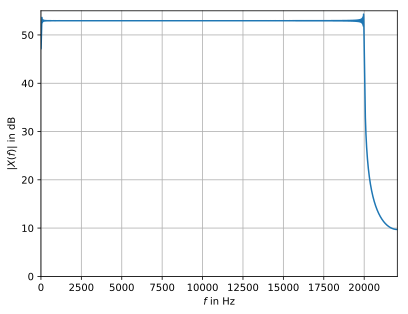

In [3]:
X = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x))*fs

plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel(r'$f$ in Hz')
plt.ylabel(r'$|X(f)|$ in dB')
plt.grid()
plt.axis([0, fs/2, 0, 55])

### Playback of Measurement Signal and Recording of Room Response

The measurement signal $x[k]$ is played through the output of the soundcard and the response $y(t)$ is captured synchronously by the input of the soundcard. The length of the played/captured signal has to be of equal length when using the soundcard. The measurement signal $x[k]$ is zero-padded so that the captured signal $y[k]$ includes the complete system response.

Be sure not to overdrive the speaker and the microphone by keeping the input level well below 0 dBFS.

In [4]:
x = np.concatenate((x, np.zeros(Tr*fs)))
y = sd.playrec(x, fs, channels=1)
sd.wait()
y = np.squeeze(y)

print('Playback level: ', 20*np.log10(max(x)), ' dB')
print('Input level: ', 20*np.log10(max(y)), ' dB')

Playback level:  -0.915149811328209  dB
Input level:  -2.4185984431271472  dB


### Computation of the Electroacoustic Transfer Function

The acoustic transfer function is computed by driving the spectrum of the system output $Y[\mu] = \text{DFT} \{ y[k] \}$ by the spectrum of the measurement signal $X[\mu] = \text{DFT} \{ x[k] \}$. Since both signals are real-valued, a real-valued fast Fourier transform (FFT) is used.

In [5]:
H = np.fft.rfft(y) / np.fft.rfft(x)

The magnitude of the transfer function is plotted for illustration

(0, 22050.0)

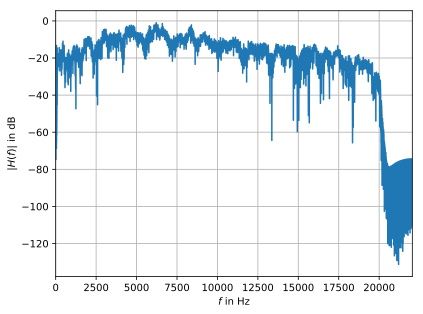

In [6]:
f = np.fft.rfftfreq(len(x))*fs
plt.plot(f, 20*np.log10(np.abs(H)))
plt.xlabel(r'$f$ in Hz')
plt.ylabel(r'$|H(f)|$ in dB')
plt.grid()
plt.xlim([0, fs/2])

### Computation of the Electroacoustic Impulse Response

The impulse response is computed by inverse DFT $h[k] = \text{IDFT} \{ H[\mu] \}$ and truncation to its assumed length

In [7]:
h = np.fft.irfft(H)
h = h[0:Tr*fs]

It is plotted for illustration

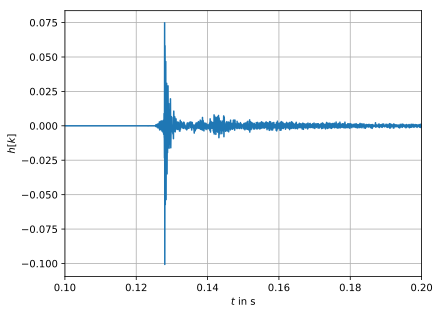

In [8]:
t = 1/fs * np.arange(len(h))
plt.plot(t, h)
plt.xlim([0.1, .2])
plt.xlabel(r'$t$ in s')
plt.ylabel(r'$h[k]$')
plt.grid()

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Lecture Notes on Signals and Systems* by Sascha Spors.